In [1]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf

In [2]:
# hyperparameters
split = (0.85);
sequence_length = 7;
epochs = 100
learning_rate = 0.02

In [3]:
# loading stock price data
stock_data = pd.read_csv("./NVDA.csv")   
column = ['Adj Close']
ma_data = pd.read_csv("./NVDA.csv")
change_data = pd.read_csv("./NVDA.csv")

<Axes: >

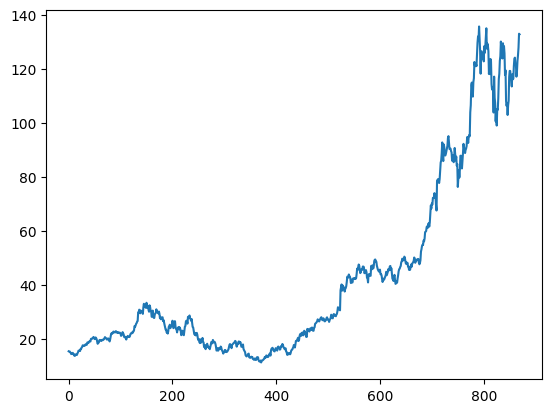

In [4]:
#show the data in the column 'close'
stock_data['Adj Close'].plot()
ma_column = ['moving_avg_7']
change_column = ['change']

In [5]:
len_stock_data = stock_data.shape[0]


In [6]:
# splitting data to train and test
train_examples = int(len_stock_data * split)
train = stock_data.get(column).values[:train_examples]
train_ma = ma_data.get(ma_column).values[:train_examples]
train_change = change_data.get(change_column).values[:train_examples]
test = stock_data.get(column).values[train_examples:]
test_ma = ma_data.get(ma_column).values[train_examples:]
test_change = change_data.get(change_column).values[train_examples:]
len_train = train.shape[0]
len_test = test.shape[0]

In [7]:
# normalizing data
scaler = MinMaxScaler()
train, test = scaler.fit_transform(train), scaler.fit_transform(test)

In [8]:
# splitting training data to x and y
X_train = []
for i in range(len_train - sequence_length):
    X_train.append(train[i : i + sequence_length])
X_train = np.array(X_train).astype(float)
y_train = np.array(train[sequence_length:]).astype(float)

# splitting testing data to x and y
X_test = []
for i in range(len_test - sequence_length):
    X_test.append(test[i : i + sequence_length])
X_test = np.array(X_test).astype(float)
y_test = np.array(test[sequence_length:]).astype(float)

In [9]:
#creating LSTM model
def model_create():
    tf.random.set_seed(1234)
    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape = (X_train.shape[1], 1)),
            tf.keras.layers.LSTM(units = 50, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.15),
            tf.keras.layers.LSTM(units = 30, activation = "tanh", return_sequences = True),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.LSTM(units = 20, activation = "tanh", return_sequences = False),
            tf.keras.layers.Dropout(0.01),
            tf.keras.layers.Dense(units = 1, activation = "linear")
        ]
    )

    model.compile(
        loss = tf.keras.losses.mean_squared_error,
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    )


    model.fit(
        X_train, y_train,
        epochs = epochs
    )
    return model


In [10]:
# inverting normaliztion
y_test = scaler.inverse_transform(y_test)


In [11]:
# prediction on test set
def predict(model):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1,1)
    return predictions


In [12]:
# evaluation
def evaluate(predictions):
    mae = mean_absolute_error(predictions, y_test)
    mape = mean_absolute_percentage_error(predictions, y_test)
    return mae, mape, (1 - mape)




In [13]:
# trial runs
def run_model(n):
    total_mae = total_mape = total_acc = 0
    for i in range(n):
        model = model_create()
        predictions = predict(model)
        mae, mape, acc = evaluate(predictions)
        total_mae += mae
        total_mape += mape 
        total_acc += acc 
    return (total_mae / n), (total_mape / n), (total_acc / n), predictions.tolist()


In [14]:
mae, mape, acc, preds = run_model(1)

print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}%")
print(f"Accuracy = {acc}")

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0270
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012    
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6479e-04
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8294e-04
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1478e-04
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8624e-04
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3139e-04
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4645e-04
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 6.1739e-04
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.6650e-04
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.5639e-04 
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8717e-04
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.1598e-04 
Epoch 15/100
23/23

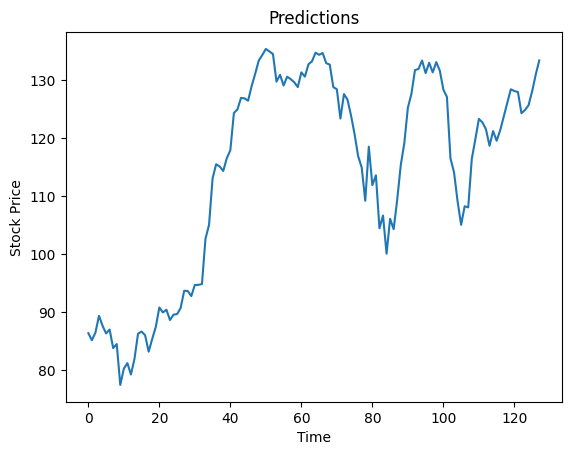

In [15]:
from matplotlib import pyplot as plt
plt.plot(preds)
plt.title("Predictions")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()


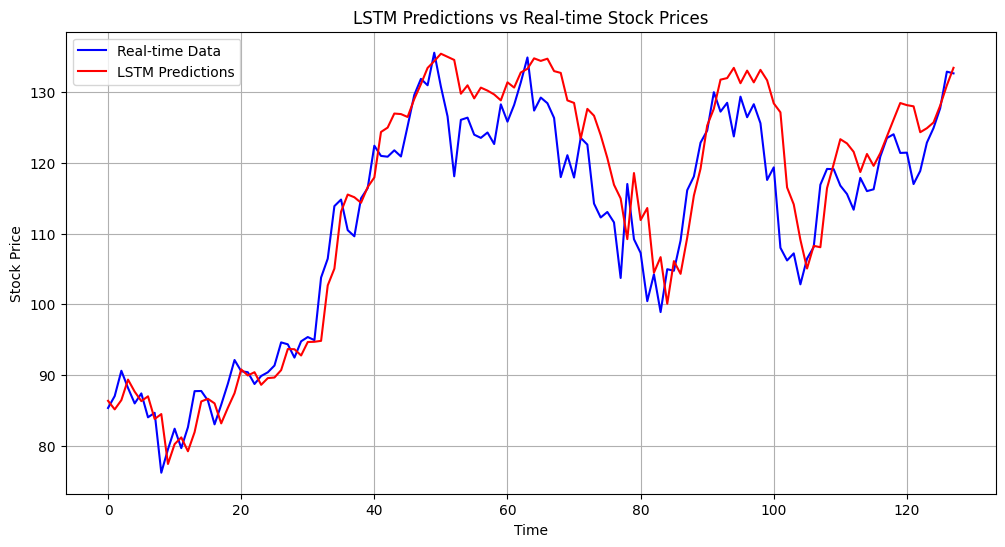

In [16]:
# Create a time axis for plotting
time_axis = range(len(y_test))

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(time_axis, y_test, label='Real-time Data', color='blue')
plt.plot(time_axis, preds, label='LSTM Predictions', color='red')
plt.title('LSTM Predictions vs Real-time Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

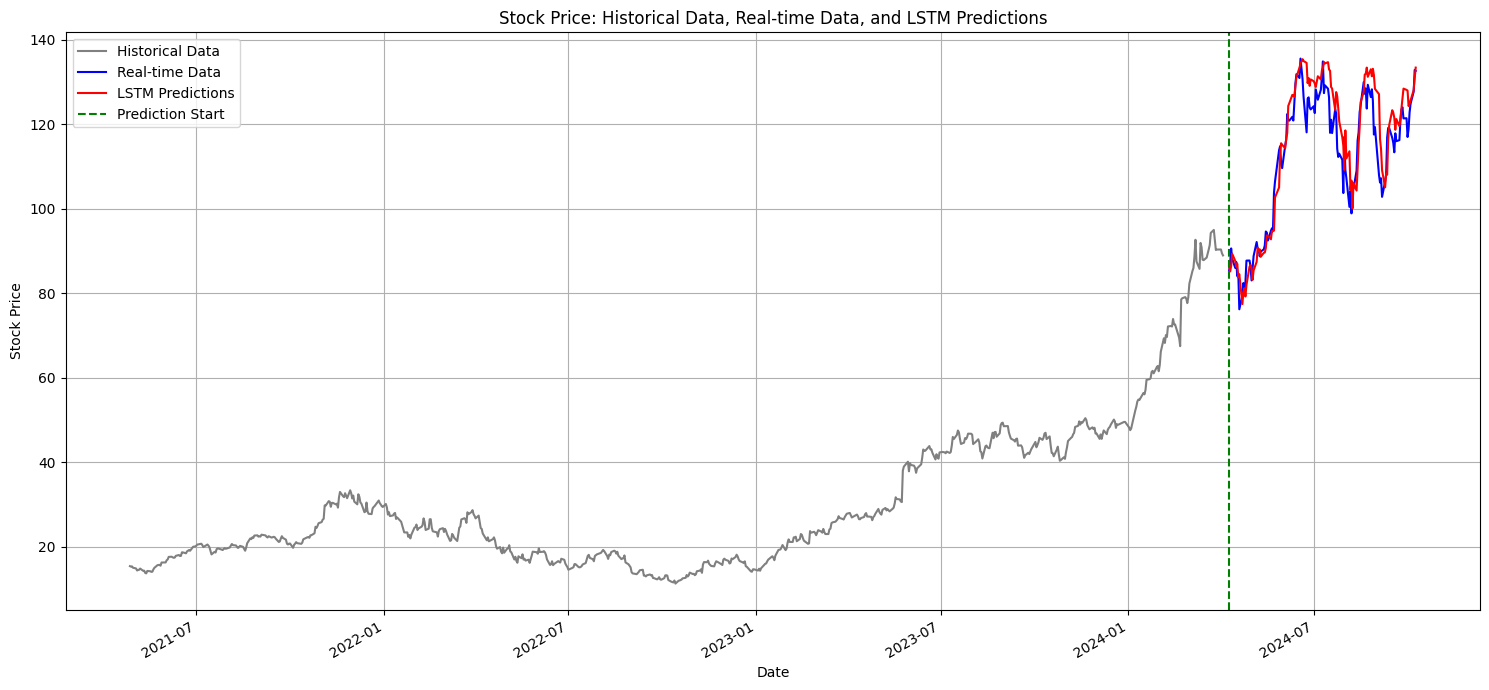

Prediction starts from: 2024-04-09


In [17]:
full_data = pd.read_csv("./NVDA.csv")
full_data['Date'] = pd.to_datetime(full_data['Date'])

prediction_start_date = full_data['Date'].iloc[train_examples + sequence_length]

historical_dates = full_data['Date'][:train_examples]
historical_prices = full_data['Adj Close'][:train_examples]

prediction_dates = full_data['Date'][train_examples + sequence_length:]
real_prices = y_test.flatten()
predicted_prices = np.array(preds).flatten()

plt.figure(figsize=(15, 7))

plt.plot(historical_dates, historical_prices, label='Historical Data', color='gray')

plt.plot(prediction_dates, real_prices, label='Real-time Data', color='blue')
plt.plot(prediction_dates, predicted_prices, label='LSTM Predictions', color='red')

# Add vertical line to separate historical and prediction data
plt.axvline(x=prediction_start_date, color='green', linestyle='--', label='Prediction Start')

plt.title('Stock Price: Historical Data, Real-time Data, and LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

plt.gcf().autofmt_xdate()

# Use a tight layout
plt.tight_layout()

# Show the plot
plt.show()

print(f"Prediction starts from: {prediction_start_date.date()}")